<a href="https://colab.research.google.com/github/helenatong/oc_p3_cleaning_dataset_and_analysis/blob/main/project3_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prerequisites**
- Download [this zip file](https://drive.google.com/file/d/1xOFMkJsbYqlR5MnkCxrgCyUOnl9zoIya/view?usp=drive_link) in Google Drive
- Modify files' path (zip_path et extract_path) within the code, 1 file in the zip


 ---

## **Context and description**

Public Health Agency France provides in opensource the database "fr.openfoodfacts.org.products", which contains information about food products sold in various points of sale.

This initiative aims to inform the public about the nutritional quality of foods. Data on each product is organized around five main themes: general product information (barcode, name), tags (packaging, category, origin, label), ingredients, nutritional information per 100g (energy, protein, sugar, sucrose, lactose), and additional information.

The objective of the study is to determine whether it is feasible to predict the values of a given variable in the dataset. The method I followed involves selecting the target variable to predict, then choosing a few relevant variables for its prediction. To determine if it is feasible, I will predict the target variable, then see the score and conclude if it's a great method. Finally, this will be followed by an exploratory analysis.

I chose to study a categorical target variable, which is the group to which the products belong.

 ---

## **Summary**

### **I. Installing and setting up the work environment**

### **II. Definitions of auxiliary functions**

### **III. xxx**

### **IV. xx**

### **V. xxxx**


# **I. Installing and setting up the work environment**

---



In [105]:
# importation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno

import zipfile
import os
import sys
import datetime

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier


In [106]:
# informations on virtual environment
print('Version of libraries :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Missingno     : ' + msno.__version__)
print('seaborn       : ' + sns.__version__)
print('matplotlib    : ' + mpl.__version__)

# print('Matplotlib    : ' + mpl.__version__)
# print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version of libraries :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Missingno     : 0.5.2
seaborn       : 0.13.1
matplotlib    : 3.7.1
Run date      : 2024-04-06T14:39:01.488417


In [107]:
# configuration on data's display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [108]:
# connection to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# unzip file

## ⚙️ if needed, modify the path
zip_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/fr.openfoodfacts.org.products.csv.zip'
extract_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

path_country = os.path.join(extract_path, 'fr.openfoodfacts.org.products.csv')

In [110]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/fr.openfoodfacts.org.products.csv', sep = '\t', low_memory = False)

In [111]:
# check data importation
print(df.head(2))

            code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                   

**CONFIGURATION**

In [112]:
TARGET = 'pnns_groups_1'
PRODUCT_NAME = 'product_name'
NUMERIC_FEATURES =  ['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
ALL_VARIABLES = NUMERIC_FEATURES + [PRODUCT_NAME] + [TARGET]

# **II. Definitions of auxiliary functions**


# **III. Exploratory phase**
---
  
- choose the target variable (1)
- select all relevant variables for target variable analysis (9)
- remove duplicates and unnecessary informations

## A. Cleaning and choice of the target variable

To choose the target variable, I first cleaned up by deleting empty columns and rows to simplify the database.
I then chose a categorical variable with a missing value greater than 50% (customer requirement). This first step is a technical constraint, then I'll use the business constraint to choose the most relevant variable to analyze.

**Cleaning**

In [113]:
# dataframe dimension
nb_row, nb_column = df.shape

print(f'number of rows : {nb_row} \nnumber of columns : {nb_column}')

number of rows : 320772 
number of columns : 162


In [114]:
# remove empty column
is_empty_column = df.isna().sum(axis = 0) == nb_row
empty_column = df.columns[is_empty_column]
print(f'{is_empty_column.sum()} columns dropped. \nList of dropped columns :\n {empty_column}')
df.drop(empty_column, axis = 1, inplace = True)

16 columns dropped. 
List of dropped columns :
 Index(['no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk',
       'butyric-acid_100g', 'caproic-acid_100g', 'lignoceric-acid_100g',
       'cerotic-acid_100g', 'melissic-acid_100g', 'elaidic-acid_100g',
       'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g',
       'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g'],
      dtype='object')


In [115]:
# remove empty rows
is_empty_row = df.isna().sum(axis = 1) == nb_column
empty_row = df.index[is_empty_row]
print(f'There is {is_empty_row.sum(axis = 0)} empty rows')

There is 0 empty rows


In [116]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

Missing value :
                                            mv(nb)    mv(%)
last_modified_t                                  0    0.00%
last_modified_datetime                           0    0.00%
creator                                          2    0.00%
created_t                                        3    0.00%
created_datetime                                 9    0.00%
code                                            23    0.01%
url                                             23    0.01%
states                                          46    0.01%
states_tags                                     46    0.01%
states_fr                                       46    0.01%
countries_fr                                   280    0.09%
countries_tags                                 280    0.09%
countries                                      280    0.09%
product_name                                 17762    5.54%
brands                                       28412    8.86%
brands_tags             

**Choose the target variable**

From a technical point of view, according to this list, the categorical variables that have between 50% and 80% missing values are the following: additives_tags, additives_fr, pnns_groups_2, pnns_groups_1, categories_fr, categories, categories_tags, main_category_fr, main_category, packaging_tags, packaging.

From a business point of view, it's interesting to be able to predict values of the group of food a product belongs to.

Let's now look at the content of the following variables.

In [117]:
main_variable_selection = ['pnns_groups_2', 'pnns_groups_1', 'categories', 'categories_tags', 'main_category']

for var in main_variable_selection:
    print('examples of values in', var , ':\n', df[var].unique()[:5], end = '\n---\n')

examples of values in pnns_groups_2 :
 [nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Bread']
---
examples of values in pnns_groups_1 :
 [nan 'unknown' 'Fruits and vegetables' 'Sugary snacks'
 'Cereals and potatoes']
---
examples of values in categories :
 [nan 'Filet de bœuf' 'Légumes-feuilles'
 'Snacks sucrés,Biscuits et gâteaux,Pâtisseries'
 'Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Breads']
---
examples of values in categories_tags :
 [nan 'fr:filet-de-boeuf'
 'en:plant-based-foods-and-beverages,en:plant-based-foods,en:fresh-foods,en:fruits-and-vegetables-based-foods,en:fresh-plant-based-foods,en:vegetables-based-foods,en:fresh-vegetables,en:leaf-vegetables'
 'en:sugary-snacks,en:biscuits-and-cakes,en:pastries'
 'en:plant-based-foods-and-beverages,en:plant-based-foods,en:cereals-and-potatoes,en:breads']
---
examples of values in main_category :
 [nan 'fr:filet-de-boeuf' 'en:fresh-vegetables' 'en:pastries' 'en:breads']
---


In [118]:
# display all element in each pnns_groups variable
print('all values in pnns_groups_1 :\n', df['pnns_groups_1'].unique(), end = '\n---\n')
print('all values in pnns_groups_2 :\n', df['pnns_groups_2'].unique())

all values in pnns_groups_1 :
 [nan 'unknown' 'Fruits and vegetables' 'Sugary snacks'
 'Cereals and potatoes' 'Composite foods' 'Fish Meat Eggs' 'Beverages'
 'Fat and sauces' 'fruits-and-vegetables' 'Milk and dairy products'
 'Salty snacks' 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']
---
all values in pnns_groups_2 :
 [nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Bread' 'Legumes'
 'Pizza pies and quiche' 'Meat' 'Sweets' 'Non-sugared beverages'
 'Sweetened beverages' 'Dressings and sauces' 'One-dish meals'
 'vegetables' 'Soups' 'Chocolate products' 'Alcoholic beverages' 'Fruits'
 'Sandwich' 'Cereals' 'Milk and yogurt' 'Fats' 'Cheese' 'Appetizers'
 'Nuts' 'Breakfast cereals' 'Artificially sweetened beverages'
 'Fruit juices' 'Eggs' 'Fish and seafood' 'Dried fruits' 'Ice cream'
 'Processed meat' 'Potatoes' 'Dairy desserts' 'Fruit nectars' 'pastries'
 'Tripe dishes' 'fruits' 'Salty and fatty products' 'cereals' 'legumes'
 'nuts']


Category variable are not homogenous in one language, I'm choosing pnns_groups_1 which is more concise as pnns_groups_2.

In [119]:
# harmonize value for the target variable
mapping = {
    'fruits-and-vegetables' : 'Fruits and vegetables',
    'sugary-snacks'   : 'Sugary snacks',
    'salty-snacks'   : 'Salty snacks',
    'cereals-and-potatoes' : 'Cereals and potatoes',
    ''   : '',
}

df[TARGET] = df[TARGET].replace(mapping)

print('updated values in {TARGET} :\n', df[TARGET].unique())

updated values in {TARGET} :
 [nan 'unknown' 'Fruits and vegetables' 'Sugary snacks'
 'Cereals and potatoes' 'Composite foods' 'Fish Meat Eggs' 'Beverages'
 'Fat and sauces' 'Milk and dairy products' 'Salty snacks']


## B. Choose revelant variable to analyze the target variable

To choose feature variable for the target variable, I prioritize variable with > 50% of available value.

In [120]:
# checing the % of available value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

Missing value :
                                            mv(nb)    mv(%)
last_modified_t                                  0    0.00%
last_modified_datetime                           0    0.00%
creator                                          2    0.00%
created_t                                        3    0.00%
created_datetime                                 9    0.00%
code                                            23    0.01%
url                                             23    0.01%
states                                          46    0.01%
states_tags                                     46    0.01%
states_fr                                       46    0.01%
countries_fr                                   280    0.09%
countries_tags                                 280    0.09%
countries                                      280    0.09%
product_name                                 17762    5.54%
brands                                       28412    8.86%
brands_tags             

Among the variables the following one are the one chosen for the analyze :
- product_name : to identify the product
- energy_100g : related to the product's nutritional value
- proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g*, fiber_100g related to the the product composition.

*I chose sodium_100g over salt_100g which is an arbitrary choice. (1g of sodium = 2,5g of salt)*


In [121]:
# drop unused variables

col_to_drop = df.columns.difference(ALL_VARIABLES)
df.drop(columns = col_to_drop, inplace = True)

In [122]:
df

,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
0,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.000
2,Peanuts,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.250
3,Organic Salted Nut Mix,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,0.482
4,Organic Polenta,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN
...,...,...,...,...,...,...,...,...,...,...
320767,Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320768,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.000
320769,乐吧泡菜味薯片,Salty snacks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320770,Tomates aux Vermicelles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## C. Cleaning the dataset with selected variables

Remove empty rows, duplicates and non informative rows

In [123]:
# remove rows without product name
removed_rows = df[PRODUCT_NAME].isna().sum()
print(f'{removed_rows} rows without product name have been removed')

df.dropna(subset=[PRODUCT_NAME], inplace=True)

17762 rows without product name have been removed


In [124]:
# remove empty rows, an empty row is NaN value for quantitative variables (does not include product_name and pnns_groups_2)
is_empty_row = df[NUMERIC_FEATURES].isna().sum(axis = 1) >= len(NUMERIC_FEATURES) - 1
empty_row = df.index[is_empty_row]
print(f'{is_empty_row.sum(axis = 0)} empty rows have been removed')

df.drop(empty_row, axis = 0, inplace = True)

44855 empty rows have been removed


In [125]:
# remove duplicates, a duplicate is 2 rows with the same product_name
nb_duplicate = df.duplicated(subset = PRODUCT_NAME).sum()
print(f'{nb_duplicate} duplicated rows have been removed')

df.drop_duplicates(subset = PRODUCT_NAME, inplace = True)
print(f'remaining rows : {df.shape[0]}')

71687 duplicated rows have been removed
remaining rows : 186468


Text(0.5, 1.0, 'Matrix of missing values \n')

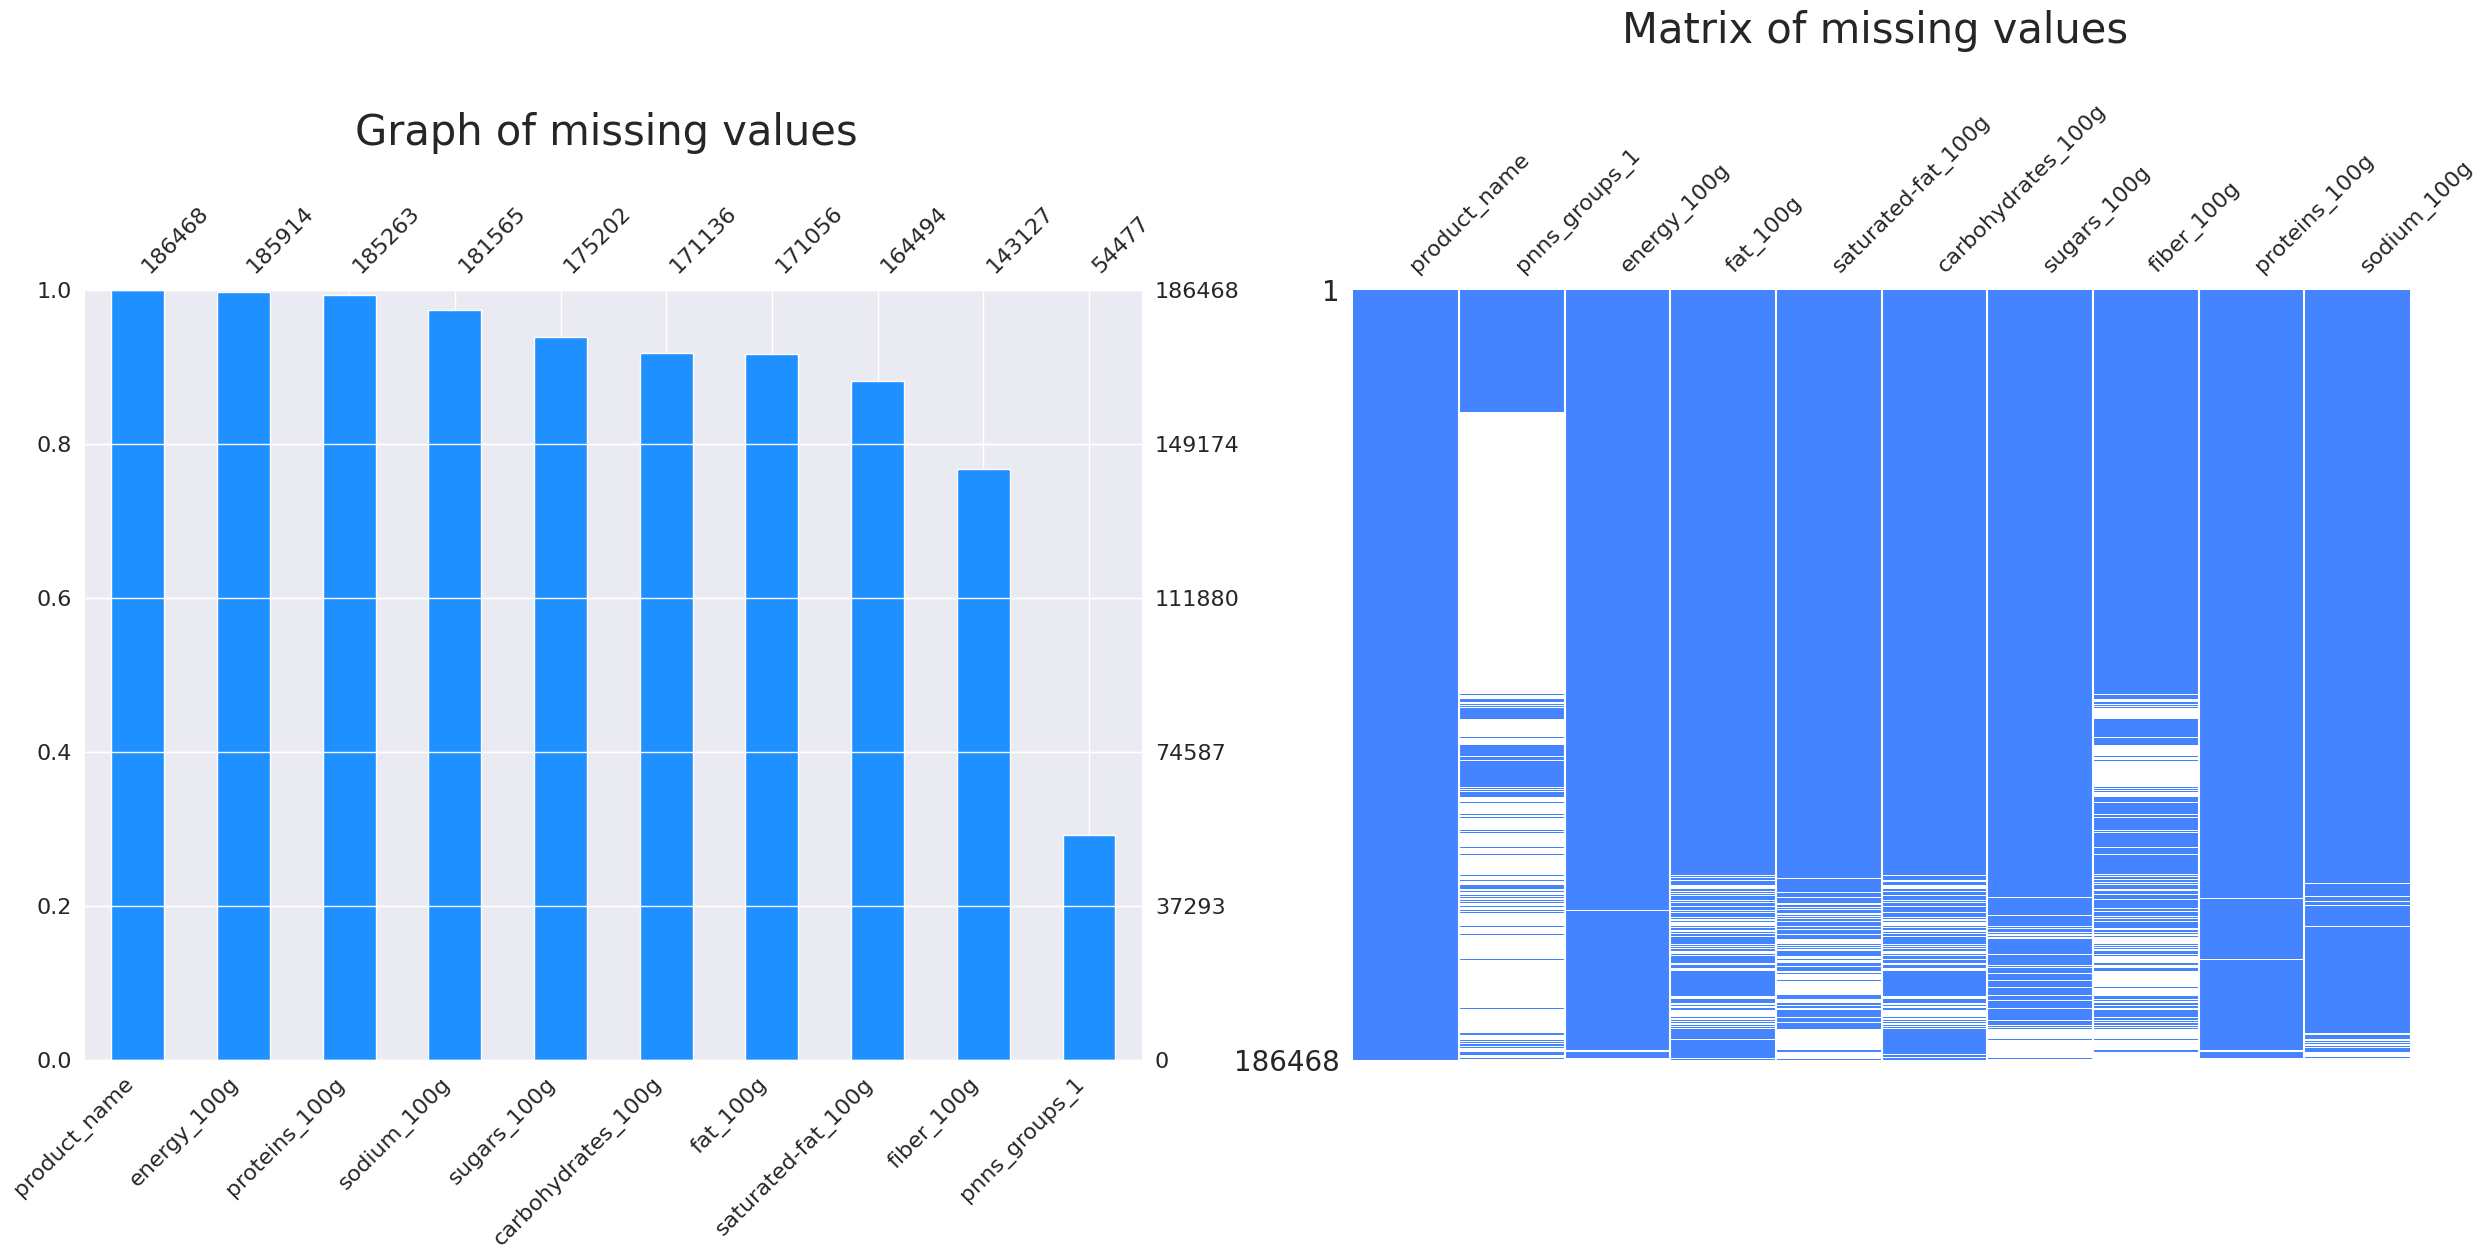

In [126]:
# matrix to see missing values
f, axes = plt.subplots(1,2, figsize=(30, 10))

msno.bar(df,
         color="dodgerblue",
         sort="descending",
         ax = axes[0]
        ).set_title("Graph of missing values \n", fontsize = 30)

msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrix of missing values \n", fontsize = 30)

# **IV. Delete impossible values deletion**
---

The quantity for the nutrient variable (proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g, fiber_100g) can not exceed 100g.

At maximum, a product can contains 900 kcal or 3766 kJ which is a product with fat_100g = 100g. Indeed 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories.

Therefore, I removed those impossible values.

In [127]:
# remove impossible value
mask = ((df['proteins_100g'] > 100) | (df['fat_100g'] > 100) | (df['saturated-fat_100g'] > 100) | (df['carbohydrates_100g'] > 100) | (df['sugars_100g'] > 100) | (df['sodium_100g'] > 100) | (df['fiber_100g'] > 100) | (df['energy_100g'] > 3766))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Number of rows removed: 310
186158 remaining


The sum of the quantity for the nutrient variables proteins_100g, fat_100g, carbohydrates_100g, sodium_100g, fiber_100g can not exceed 100g

In [128]:
# remove impossible value
mask = (df['proteins_100g'] + df['fat_100g'] + df['carbohydrates_100g'] + df['sodium_100g'] + df['fiber_100g'] > 100)
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Number of rows removed: 13693
172465 remaining


Quantitative variables can not be negative

In [129]:
# remove impossible value
mask = ((df['proteins_100g'] < 0) | (df['fat_100g'] < 0) | (df['saturated-fat_100g'] < 0) | (df['carbohydrates_100g'] < 0) | (df['sugars_100g'] < 0) | (df['sodium_100g'] < 0) | (df['fiber_100g'] < 0) | (df['energy_100g'] < 0))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Number of rows removed: 8
172457 remaining


According to business rule : fat_100g > saturated-fat_100g and carbohydrates_100g > sugars_100g

In [130]:
# remove impossible value
mask = ((df['fat_100g'] < df['saturated-fat_100g']) | (df['carbohydrates_100g'] < df['sugars_100g']))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Number of rows removed: 756
171701 remaining


# **V. Data pre-processing by imputation : Replace NaN values**

To replace missing values, here is the logic :
- Understanding the characteristics of a variable

  Missing value for fiber means that the product doesn't contain any

- See if there are correlations between certain variables to use linear regression imputation.
- As for the order on which variable to imput first, I will start with the most accurate estimates (correlated variable, fiber = 0) before imputing with less precise method like statistical ones

In [131]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))

Missing value :
                    mv(nb)   mv(%)
product_name             0   0.00%
energy_100g            536   0.31%
proteins_100g         1183   0.69%
sodium_100g           4878   2.84%
sugars_100g          11026   6.42%
carbohydrates_100g   15250   8.88%
fat_100g             15337   8.93%
saturated-fat_100g   21720  12.65%
fiber_100g           43104  25.10%
pnns_groups_1       117984  68.71%


When the value of fiber_100g is missing, the product contains none

In [132]:
df['fiber_100g'] = df['fiber_100g'].fillna(0)

Let's see correlation matrix to identify methods which can be use to impute values


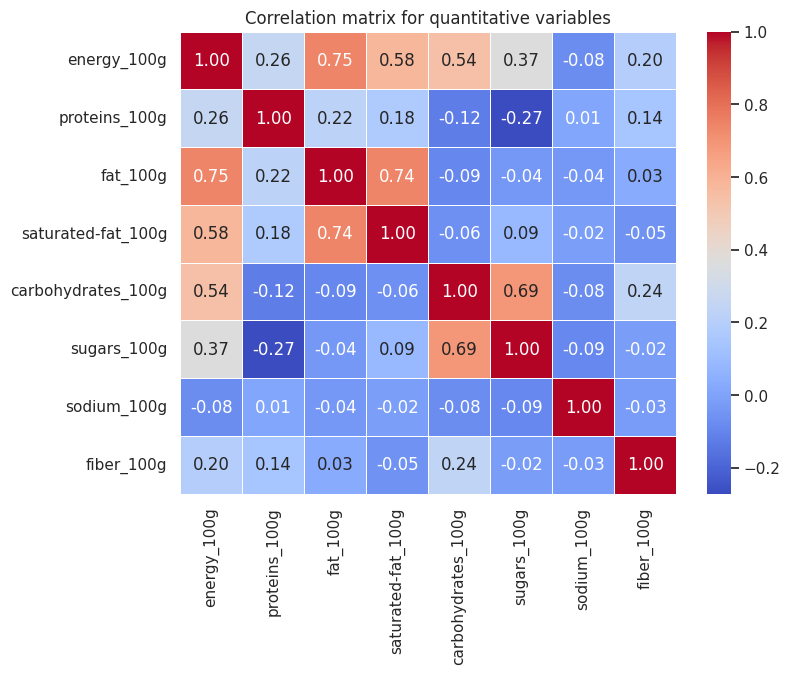

In [133]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

The couple fat/saturated fat and sugars/carbohydrates have a correlation of 0.75 and 0.69 respectively.

Let's plot a graph to check the linearity of the values.


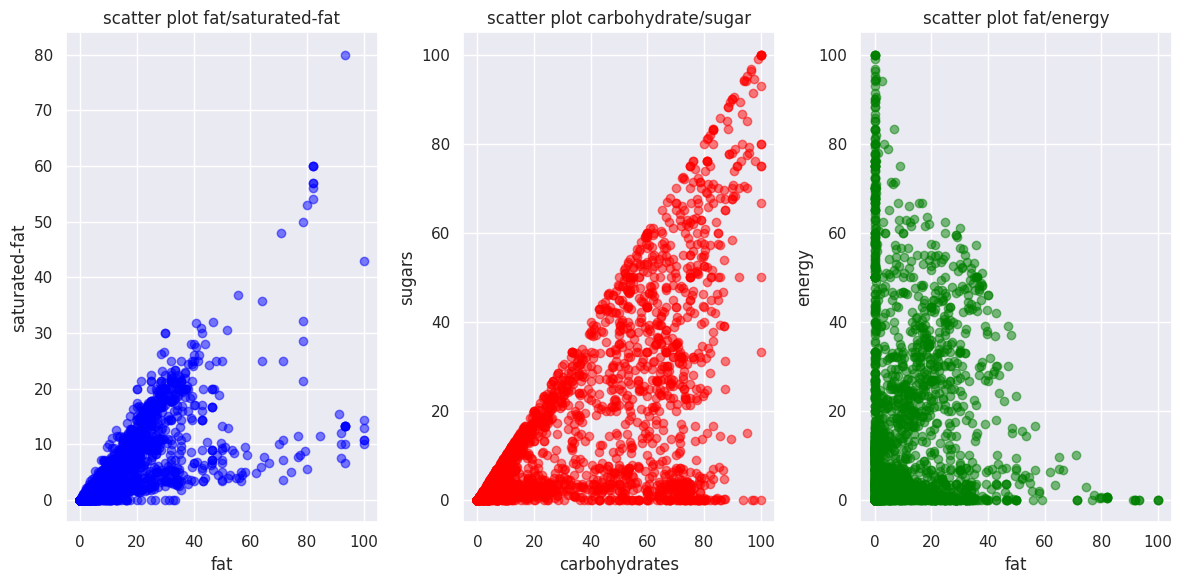

In [134]:
# extract a sample to have a proper view
df_sample = df.sample(3000)

fat = df_sample['fat_100g']
sfat = df_sample['saturated-fat_100g']
carbohydrate = df_sample['carbohydrates_100g']
sugar = df_sample['sugars_100g']
energy = df_sample['sugars_100g']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# first graph
ax1.scatter(fat, sfat, alpha=0.5, color='blue')
ax1.set_title('scatter plot fat/saturated-fat')
ax1.set_xlabel('fat')
ax1.set_ylabel('saturated-fat')
ax1.grid(True)

# second graph
ax2.scatter(carbohydrate, sugar, alpha=0.5, color='red')
ax2.set_title('scatter plot carbohydrate/sugar')
ax2.set_xlabel('carbohydrates')
ax2.set_ylabel('sugars')
ax2.grid(True)

# second graph
ax3.scatter(fat, energy, alpha=0.5, color='green')
ax3.set_title('scatter plot fat/energy')
ax3.set_xlabel('fat')
ax3.set_ylabel('energy')
ax3.grid(True)

plt.tight_layout()
plt.show()

The linearity is not obvious, I will use KKNImputer method to imput values for sodium, proteins, fat, saturated-fat, sugars, carbohydrates.

In [135]:
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['sodium_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute]) #12min

Since 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories, I can deduct the energy value

In [136]:
df.loc[df['energy_100g'].isna(), 'energy_100g'] = 4 * df['proteins_100g'] + 4 * df['carbohydrates_100g'] + 9 * df['fat_100g'] + 2 * df['fiber_100g']

## DRAFT Compare distribution before and after imputation

In [137]:
# num_feature_variable = ['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
# fig, axes = plt.subplots(nrows = 8, ncols = 1, figsize=(10,40))

# for i in range (0, len(num_feature_variable)):
#   var = num_feature_variable[i]
#   sns.histplot(x = df[var], y =  df[var].count(), ax = axes[i])
#   axes[i].set_title(f'Distribution of {var} per 100g :\n', fontsize=10)
#   axes[i].set_xlabel('')
#   axes[i].set_ylabel('', fontsize=30)
#   axes[i].tick_params(axis='x', labelsize=15, rotation = 45)
#   axes[i].tick_params(axis='y', labelsize=15)
#   axes[i].grid(True)

# plt.tight_layout()

# # ce que je veux c'est un histogramme avec le ordonnée le count et en abscice les valeurs de prot

# **VI. Predict and Access the quality of prediction**


Delete NaN value for target variable to train and test models

In [191]:
# df.to_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', index=False)

In [174]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', sep = ',', low_memory = False)

                                             product_name  \
171696                                  Raspados Ice Bars   
171697                Tartines craquantes bio au sarrasin   
171698                                        Test NF App   
171699                                 Thé vert Earl grey   
171700  Mint Melange Tea A Blend Of Peppermint, Lemon ...   

               pnns_groups_1  energy_100g  fat_100g  saturated-fat_100g  \
171696                   NaN        368.0       0.0                 0.0   
171697  Cereals and potatoes       1643.0       2.8                 0.6   
171698                   NaN        569.0      31.0                 8.7   
171699             Beverages         21.0       0.2                 0.2   
171700                   NaN          0.0       0.0                 0.0   

        carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  \
171696               21.05         19.3         0.0            0.0   
171697               74.80          2.6   

,index,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
0,0,Organic Polenta,NaN,1552.0,1.430000,0.00,77.14,2.856667,5.7,8.57,0.219000
1,1,Breadshop Honey Gone Nuts Granola,NaN,1933.0,18.270000,1.92,63.46,11.540000,7.7,13.46,0.204724
2,2,Organic Long Grain White Rice,NaN,1490.0,2.593333,0.00,80.00,2.963333,0.0,8.89,0.474000
3,3,Organic Dark Chocolate Minis,NaN,2406.0,37.500000,22.50,55.00,42.500000,7.5,5.00,0.158478
4,4,Organic Sunflower Oil,NaN,3586.0,100.000000,7.14,0.00,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
171696,171696,Raspados Ice Bars,NaN,368.0,0.000000,0.00,21.05,19.300000,0.0,0.00,0.018000
171697,171697,Tartines craquantes bio au sarrasin,Cereals and potatoes,1643.0,2.800000,0.60,74.80,2.600000,5.9,13.00,0.267717
171698,171698,Test NF App,NaN,569.0,31.000000,8.70,12.20,9.600000,1.1,2.10,0.433071
171699,171699,Thé vert Earl grey,Beverages,21.0,0.200000,0.20,0.50,0.500000,0.2,0.50,0.010000


In [193]:
# remove NaN value for TARGET
rows_before = df.shape[0]
df.dropna(subset = TARGET, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')
# print(df.loc[df[TARGET].isna(),:])
# print(df[TARGET].unique())

Number of rows removed: 0
43468 remaining


In [194]:
# remove unknown value for TARGET
nb_rows_to_remove = df.loc[df[TARGET] == 'unknown', TARGET].count()
df = df[df[TARGET] != 'unknown']
rows_now = df.loc[df[TARGET] != 'unknown', TARGET].count()

rows_removed = rows_before - rows_now
print(f'Number of rows removed: {nb_rows_to_remove}\n{rows_now} remaining')

Number of rows removed: 0
43468 remaining


In [189]:
print(df.shape)
df

(43468, 10)


,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
0,Salade Cesar,Fruits and vegetables,1210.0,12.000000,7.000000,23.000000,0.000000,2.000,22.000,0.850000
1,Danoises à la cannelle roulées,Sugary snacks,1520.0,14.400000,12.836667,54.100000,28.100000,2.050,4.790,0.363000
2,Chaussons tressés aux pommes,Sugary snacks,1090.0,10.700000,2.000000,38.700000,24.700000,2.000,3.330,0.255000
3,Quiche Lorraine,Composite foods,478.0,6.790000,2.860000,7.860000,0.714000,0.357,5.360,0.196000
4,Pâté au poulet,Fish Meat Eggs,751.0,10.200000,0.366667,16.600000,19.476667,0.000,33.900,0.289000
...,...,...,...,...,...,...,...,...,...,...
43463,Santa Cruz Chilli & Lime Dressing,Fat and sauces,660.0,6.900000,0.500000,23.100000,16.700000,0.600,0.300,0.213000
43464,Fisherman's Friend Miel-Citron,Sugary snacks,1031.0,1.300000,1.280000,95.310000,0.100000,1.470,0.004,0.000394
43465,Nature cheddar and red onion crisps,Salty snacks,2155.0,22.866667,3.400000,34.766667,1.800000,5.600,7.800,0.531496
43466,Tartines craquantes bio au sarrasin,Cereals and potatoes,1643.0,2.800000,0.600000,74.800000,2.600000,5.900,13.000,0.267717


In [190]:
df[TARGET].value_counts(normalize=True)

pnns_groups_1
Sugary snacks              0.199296
Milk and dairy products    0.142289
Cereals and potatoes       0.131591
Composite foods            0.119306
Beverages                  0.110012
Fish Meat Eggs             0.108310
Fruits and vegetables      0.080703
Fat and sauces             0.065704
Salty snacks               0.042790
Name: proportion, dtype: float64

In [192]:
# normalize values
from sklearn.preprocessing import PowerTransformer, LabelEncoder

transformer = PowerTransformer() #model which normalize values
df_int_transformed = transformer.fit_transform(df[NUMERIC_FEATURES]) #array
df_int_transformed = pd.DataFrame(df_int_transformed, columns=NUMERIC_FEATURES)
print(df_int_transformed)
df_transformed = pd.concat([df_int_transformed, df[[PRODUCT_NAME, TARGET]]], axis=1)
# print(df_transformed)

       energy_100g  proteins_100g  fat_100g  saturated-fat_100g  \
0         0.372860       1.584887  0.502489            0.859361   
1         0.691067      -0.072251  0.635760            1.248449   
2         0.237585      -0.374100  0.419727           -0.009990   
3        -0.635545       0.028551  0.101076            0.237279   
4        -0.196798       2.168014  0.385446           -0.906903   
...            ...            ...       ...                 ...   
43463    -0.331366      -1.475647  0.112039           -0.789849   
43464     0.168035      -1.683983 -0.846543           -0.300352   
43465     1.245073       0.389935  0.981496            0.358843   
43466     0.807221       0.942891 -0.457991           -0.710514   
43467    -2.109685      -1.356225 -1.346986           -1.075759   

       carbohydrates_100g  sugars_100g  sodium_100g  fiber_100g  
0                0.264068    -1.598931     1.446606    1.021683  
1                1.029894     1.153421     0.571878    1.037028

In [195]:
# check transformation values
df_transformed[NUMERIC_FEATURES].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,energy_100g,proteins_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,sodium_100g,fiber_100g
count,43468.00,43468.00,43468.00,43468.00,43468.00,43468.00,43468.00,43468.00
mean,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.49,-1.69,-1.49,-1.32,-1.71,-1.60,-1.22,-0.88
25%,-0.82,-0.83,-0.92,-0.97,-0.81,-0.90,-0.98,-0.88
50%,0.10,0.13,0.04,-0.01,-0.06,-0.06,-0.02,-0.88
75%,0.80,0.70,0.91,0.91,1.00,0.85,0.85,1.05
max,2.33,3.65,2.13,2.24,1.68,1.93,2.31,1.90


array([[<Axes: title={'center': 'energy_100g'}>,
        <Axes: title={'center': 'proteins_100g'}>,
        <Axes: title={'center': 'fat_100g'}>],
       [<Axes: title={'center': 'saturated-fat_100g'}>,
        <Axes: title={'center': 'carbohydrates_100g'}>,
        <Axes: title={'center': 'sugars_100g'}>],
       [<Axes: title={'center': 'sodium_100g'}>,
        <Axes: title={'center': 'fiber_100g'}>, <Axes: >]], dtype=object)

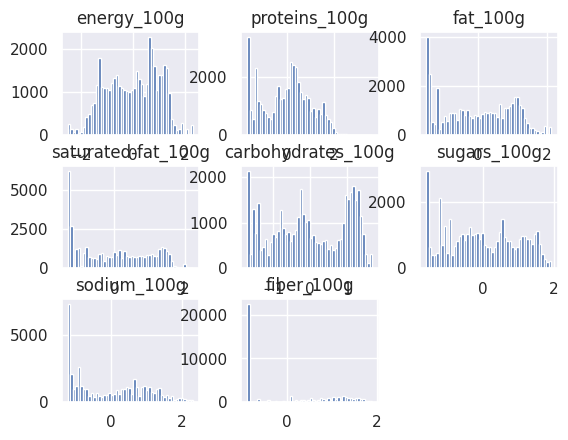

In [196]:
# check transformation distribution
df_transformed[NUMERIC_FEATURES].hist(bins=50)

In [205]:
# create dataset for training and testing

# transform the class form text to integer
X = df_transformed[NUMERIC_FEATURES].values

print(df_transformed[TARGET].values)
encoder =  LabelEncoder()
y_encoded = encoder.fit_transform(df_transformed[TARGET].values)
# to reverse y_initial = encoder.inverse_transform(y_encoded)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

## TO DROP
# print(y_encoded)
# print( encoder.inverse_transform(y_encoded))
# y_decoded = encoder.inverse_transform(y_encoded)
# unique_values_decoded = np.unique(y_decoded)
# print(unique_values_decoded)

['Fruits and vegetables' 'Sugary snacks' 'Sugary snacks' ...
 'Salty snacks' 'Cereals and potatoes' 'Beverages']


In [ ]:
# model = HistGradientBoostingClassifier(max_iter=100, max_depth=6, learning_rate=0.1)

In [206]:
# fit model by using grid search
param_grid ={
    'max_iter'          : [100],
    'max_depth'         : [3, 6],
    'learning_rate'     : [0.1]
}

grid_search = GridSearchCV(HistGradientBoostingClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)
print(grid_search.best_params_)

# model scoring
best_model = grid_search.best_estimator_
print(f'Model\'s score : {best_model.score(X_train, y_train_encoded).round(3)}')
print(f'Model\'s score on test dataset : {best_model.score(X_test, y_test_encoded).round(3)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 100}
Model's score : 0.937
Model's score on test dataset : 0.875


The best model obtained is overfitted on training dataset

In [204]:
# check prediction's details
y_pred_encoded = best_model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
y_test = encoder.inverse_transform(y_test_encoded)
print(classification_report(y_test, y_pred))


                         precision    recall  f1-score   support

              Beverages       0.93      0.88      0.91       949
   Cereals and potatoes       0.86      0.82      0.84      1140
        Composite foods       0.79      0.81      0.80      1062
         Fat and sauces       0.88      0.83      0.86       579
         Fish Meat Eggs       0.90      0.91      0.90       954
  Fruits and vegetables       0.76      0.77      0.76       651
Milk and dairy products       0.90      0.94      0.92      1212
           Salty snacks       0.82      0.81      0.82       394
          Sugary snacks       0.91      0.94      0.93      1753

               accuracy                           0.87      8694
              macro avg       0.86      0.86      0.86      8694
           weighted avg       0.87      0.87      0.87      8694



<Axes: >

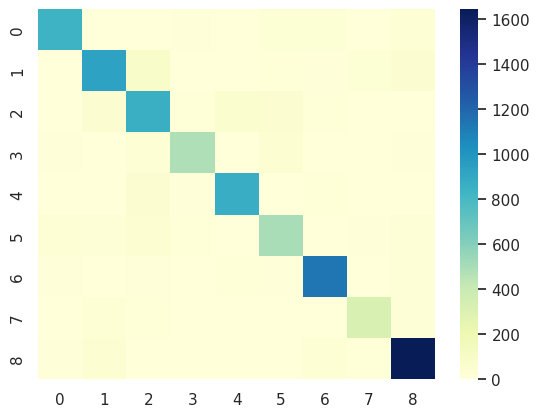

In [217]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred = y_pred) , cmap="YlGnBu")

In [ ]:
encoder.inverse_transform([24, 33])

In [ ]:
# # check prediction's details
# unique_labels = df['pnns_groups_2'].unique()
# confusion_matrix_array = confusion_matrix(y_test, y_pred)
# confusion_matrix_df = pd.DataFrame(data=confusion_matrix_array, index=unique_labels, columns=unique_labels)

# mask = confusion_matrix_df.loc[unique_labels != 0]
# confusion_matrix_df.loc[confusion_matrix_df.index.isin(['Fats', 'Dried fruits']) & mask, :]


Let's see if we can improve our model by increasing the amount of data provided using the learning curve method.

In [218]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(best_model, X_train, y_train_encoded,
                                           train_sizes = np.linspace(0.1, 1.0, 5), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_size')
plt.legend()

KeyboardInterrupt: 

A plateau seems to be reached at 30,000, but the model can be improved with more data

**Conclusion on the on the feasibility of predicting the target variable**

The main objective is to determine if it is feasible to find a prediction method to fill in the missing data of the target variable pnns_groups_2.

The training dataset achieves a score of 98%, while the test dataset achieves a score of 64%, indicating overfitting.

However, this result is encouraging and represents a good score. Furthermore, it is possible to improve it through various means such as variable selection, imputation method, and model parameter tuning.

Additionally, it may be interesting to predict the values of the variable pnns_groups_1 as it has fewer categories and may yield more reliable predictions.

# **VII. Data analysis**

## **A. Univariate an Bivariate analysis**

In [ ]:
# statistic information
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

In [ ]:
#plot all boxbot to have a general view
comp_feature_variable = ['proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
df_melted = pd.melt(df, id_vars = [PRODUCT_NAME, TARGET], value_vars = comp_feature_variable , var_name='variable', value_name='value')

ax = sns.boxplot(x = 'variable', y = 'value', data = df_melted.loc[df_melted['variable'].isin(comp_feature_variable), :])
ax.set_title('Distribution of variable per 100g :\n', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation = 45)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# category distribution
category_counts = df[TARGET].value_counts()

category_percentages = (category_counts / len(df)) * 100
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(category_counts.index, category_counts.values, color='b')

ax2 = ax1.twinx()
ax2.bar(category_counts.index,category_percentages.values, color='b')

ax2.set_ylabel('Percentage (%)')
ax1.set_ylabel('Total')
ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')

plt.title('Distribution of categories')
plt.tight_layout()
plt.show()

print(category_percentages)

In [ ]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

In [ ]:
# display variables pairing

sns.pairplot(df.sample(10000), height=2, diag_kind= None, corner=True)
plt.show()

In [ ]:
# Créer des boxplots pour chaque variable quantitative en fonction de la variable cible
# Créer une grille de subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

# Flatten la grille de subplots pour un accès plus facile
axes = axes.flatten()

top_categories = df[TARGET].value_counts().index[:5]

# Créer un boxplot pour chaque variable quantitative
for i, var in enumerate(NUMERIC_FEATURES):
    sns.boxplot(y=TARGET, x=var, data=df[df[TARGET].isin(top_categories)], ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by {TARGET}')
    axes[i].set_xlabel(TARGET)
    axes[i].set_ylabel(var)
    if i == 6:
      axes[i].set_xlim(0, 10)

plt.tight_layout()
plt.show()


## **B. Multivariate analysis**


In [ ]:
# df.to_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', sep = ',', low_memory = False)

In [ ]:
sns.set()

In [ ]:
#Conserver uniquement les variables quantitatives
df1 = df[NUMERIC_FEATURES]
X = df1.values #Transformation d'une ligne/produit en vecteur = une liste

In [ ]:
# centrer et réduire les données
scaler = StandardScaler() #instantiation
X_scaled = scaler.fit_transform(X)

#vérification
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

In [ ]:
# faire l'ACP avec les données centrées-réduites
n_components = 8 #== min(n_samples, n_features)
pca = PCA(n_components=n_components) #instanciation, n_components
pca.fit(X_scaled)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
# éboulie
scree = (pca.explained_variance_ratio_*100).round(2)

# somme cumulée éboulie
scree_cum = scree.cumsum().round()

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
#% d'inertie par axe composante principale
pcs = pca.components_
pcs = pd.DataFrame(pcs * 100).round()
pcs.columns = NUMERIC_FEATURES
pcs.index = [f"F{i}" for i in x_list]
pcs

In [ ]:
pcs.T

In [ ]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                NUMERIC_FEATURES[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [ ]:
x_y = (0,1)
x_y

correlation_graph(pca, x_y, NUMERIC_FEATURES)

In [ ]:
correlation_graph(pca, (2,3), NUMERIC_FEATURES)

## Individus

In [ ]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

In [ ]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='12', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Données d'exemple
X = X_proj

# Nombre de clusters souhaités
n_clusters = df[TARGET].nunique()

# Créer un modèle K-means
kmeans = KMeans(n_clusters=n_clusters)

# Adapter le modèle aux données
kmeans.fit(X)

# Obtenir les centres de chaque cluster
cluster_centers = kmeans.cluster_centers_

# Visualiser les centres des clusters
print("Centres des clusters :")
print(cluster_centers)


In [ ]:
x_y = [0,1]
unique_values = df[TARGET].unique()
# print(cluster_centers)

# Appeler display_factorial_planes avec les coordonnées x et y
display_factorial_planes(cluster_centers, x_y, labels=unique_values, alpha=1, figsize=(25, 20), clusters=unique_values)

In [ ]:
# # x_y = [0,1]
# # display_factorial_planes(X_proj, x_y, figsize=(20, 16), clusters=df[TARGET])
# unique_values = df[TARGET].unique()
# print(unique_values)
# print(unique_values)

In [ ]:
x_y = [1,2]
unique_values = df[TARGET].unique()
print(unique_values)
print(cluster_centers)

# Appeler display_factorial_planes avec les coordonnées x et y
display_factorial_planes(cluster_centers, x_y, labels=unique_values, alpha=1, figsize=(25, 20), clusters=unique_values)


# **Conclusion**

## Pipeline

Test pour déterminer les NaN de energy_100g à partir des autres variables quantititatives

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer, SimpleImputer
# from sklearn.utils.validation import check_is_fitted

# X = df[comp_feature_variable]
# y = df['energy_100g']

In [ ]:
# # Code Raphaël ici: comment récupére les indices où y est non nul
# y = np.array([np.NaN, 1, 100, 19, np.NaN])

# y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()

# y_non_null = y[y_non_null_idx]
# y_non_null

In [ ]:
# from enum import Enum
# from sklearn.base import BaseEstimator, TransformerMixin

# class EnergyImputer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X['energy_100g'] = X.apply(lambda row: 4 * row['proteins_100g'] + 4 * row['carbohydrates_100g'] + 9 * row['fat_100g'] + 2 * row['fiber_100g'], axis=1)
#         return X

# # Importer les modules nécessaires
# from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer
# from sklearn.linear_model import LinearRegression

# # Définir les étapes de la pipeline, instantiation
# my_transformer = EnergyImputer()
# my_imputer = KNNImputer(n_neighbors=3)
# my_regressor = LinearRegression()

# # Créer la pipeline
# my_pipeline = Pipeline([
#     ('transformer', my_transformer),
#     ('imputer', my_imputer),
#     ('regressor', my_regressor)
# ])

# # Code Raphaël
# # OPTION 1: Option "Plus Facile": avec les pipelines
# # Etape 1: On va commencer par filtrer X et y là où y est non nul
# y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()

# X_with_y_non_null = X[y_non_null_idx, :]
# y_non_null = y[y_non_null_idx]

# my_pipeline1 = Pipeline([
#     ('imputer', my_imputer),
#     ('regressor', my_regressor)
# ])

# my_pipeline2 = Pipeline([
#     ('transformer', my_transformer),
#     ('regressor', my_regressor)
# ])

# # Etape 2: on fit chaque pipeline avec si on veut un grid search et une cross validation
# # ...


# # OPTION 2: Option "Difficile" sans les pipelines
# # - Imputer : toutes les données
# # - Regressor: seulement les données avec y non NaN

# my_transformer = EnergyImputer()
# my_imputer = KNNImputer(n_neighbors=3)

# class METHOD_IMPUTATION(Enum):
#   ENERGY_IMPUTER = 'ENERGY_IMPUTER'
#   KNN = 'KNN'
#   TROISIEME_OPTION = 'NIMPORTE QUEL TEXTE'

# def fit_one_regressor(method_imputation):
#   # Le code ici fait l'hypothese que X et y sont des numpy array. a adapter
#   # dans le cas où ce sont des pandas ou series
#   # X = toutes les lignes
#   # y = toutes les lignes

#   # Etape 1: on impute X en utilisant toutes les données
#   if method_imputation == 'energy': # METHOD_IMPUTATION.ENERGY_IMPUTER:
#     X_transform = my_transformer.fit_transform(X)

#   elif method_imputation == 'imputer': # METHOD_IMPUTATION.KNN:
#     X_transform = my_imputer.fit_transform(X)

#   else:
#     raise NotImplementedError

#   # Etape 2: Maintenant on ne garde que X et y où y est non nul
#   y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()
#   X_transform_for_regressor = X_transform[y_non_null_idx, :]
#   y_non_null = y[y_non_null_idx]

#   # On fit le modèle de prédiction là où y est non nul
#   my_regressor = LinearRegression()
#   my_regressor.fit(X_transform_for_regressor, y_non_null)
#   return my_regressor


# # Application:
# fit_one_regressor('energy')


In [ ]:
# # En même temps, on fit le KNNImputer ET la régression
# my_pipeline.fit(X, y) #entrainement

In [ ]:
# # On peut accéder aux élements individuels de la pipeline
# # Ici, les éléments qu'on récupère sont fittés
# my_fitted_transformer = my_pipeline.steps[0][1]
# my_fitted_imputer = my_pipeline.steps[1][1]
# my_fitted_regressor = my_pipeline.steps[2][1]

In [ ]:
# my_fitted_regressor.coef_

In [ ]:
# # Le code pour récupérer l'output de la première étape (entre KNNImputer et LinearRegression)
# # Quasiment tous les objets de sklearn ont 3 méthodes:
# # - fit
# # - fit_transform
# # - transform
# my_fitted_imputer.transform(X) #imputation des valeurs manquante

In [ ]:
# from sklearn.model_selection import GridSearchCV

# my_param_grid = {
#     'imputer__n_neighbors': [2, 3, 4],
#     'regressor__fit_intercept': [True, False]
# }

# from sklearn.metrics import mean_absolute_error


# gs = GridSearchCV(
#     estimator=my_pipeline,
#     param_grid=my_param_grid,
#     n_jobs=-1,
#     cv=3,
#     refit=True,  # Please refit again the best of all models on ALL Training data
#     # error_score=mean_absolute_error  # Check how to change the error_score
# )



In [ ]:
# gs.fit(X, y)

# # Visuzlize the Cross Validation results
# # 1 row by model
# # k columns for every k in the cross validation
# pd.DataFrame(gs.cv_results_)

# my_best_model = gs.best_estimator_

# y_pred = my_best_model.predict(X)

# import matplotlib.pyplot as plt

# plt.scatter(y, y_pred)

#brouillons

In [ ]:
# '''
#     Parameters :
#     series (pandas.serie): A serie of numerical value

#     Return :
#     series (pandas.serie): A filtered serie which contains only outliers
# '''

# def mark_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     mask = (df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)
#     return mask

# for var in num_feature_variable:
#     df[f'{var}_is_outlier'] = mark_outliers(df, var)

In [ ]:
# # number of outliers per variable
# print('outliers by variable : \n---')
# tot_outlier = 0
# for var in num_feature_variable:
#     count_outlier = df.loc[df[f'{var}_is_outlier'], var].count()
#     tot_outlier += count_outlier
#     print(f'{var} : {count_outlier}')
# print(f'\ntotal : {tot_outlier}')

In [ ]:
# # fit and predict by using grid search

# from  sklearn.neighbors import KNeighborsClassifier
# # instantiation de l'objet model
# model = KNeighborsClassifier()

# from sklearn.model_selection import train_test_split
# #Separation des données d'entrainement
# X = df[comp_feature_variable]
# y = df['pnns_groups_2']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # entrainement du modèle de données
# model.fit(X_train, y_train)

# # evaluation du modèle
# print(model.score(X_train, y_train))

In [ ]:
# #Regarder la qualité des prédictions

# from sklearn.metrics import accuracy_score
# # utiliser le modèle pour prédire les valeurs
# y_pred = model.predict(X_test)

# # Calculer la précision
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

# from sklearn.metrics import classification_report
# # Afficher le rapport de classification
# print(classification_report(y_test, y_pred))

# from sklearn.metrics import confusion_matrix
# # Calculer la matrice de confusion
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)